In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedShuffleSplit, train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Transformers 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, PrecisionRecallDisplay


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# <u>**LOADING THE DATA**</u>
The dataset is appropriately loaded and stored into corresponding variables.

In [2]:
testDataset = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
trainDataset = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
moviesDataset = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# <u>**EXPLORATORY DATA ANALYSIS & DATA CLEANING**</u>

## **EDA : About Train Dataset**

We will work and process on the copy of the original dataset.

In [3]:
trainD = trainDataset.copy()

In [4]:
trainD.shape

(162758, 5)

In [5]:
trainD.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [6]:
# Checking datatypes and null values info

trainD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [7]:
# Basic Statistics of Data

trainD.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [8]:
# Checking Duplicates

trainD.duplicated().sum()

1118

In [9]:
trainD['sentiment'][trainD.duplicated()].value_counts()

POSITIVE    747
NEGATIVE    371
Name: sentiment, dtype: int64

* This clearly shows that how much duplicate values are skewing the data towards `POSITIVE` sentiment.
* Let's drop the duplicate rows from train dataset.

In [10]:
trainD['sentiment'].value_counts()

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

* The above values points towards an imbalanced dataset. We can view it from a bar chart.

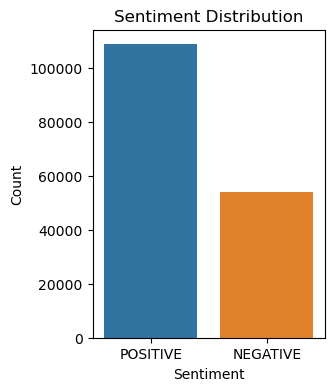

In [11]:
# Label --> Sentiment

fig, axes = plt.subplots(1,1 , figsize=(3, 4))
sns.countplot(x='sentiment', data = trainD)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [12]:
# Checking Missing Values

trainD.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

## **EDA : About Movies Dataset**

We will work and process on the copy of the original dataset.

In [13]:
moviesD = moviesDataset.copy()

In [14]:
moviesD.shape

(143258, 14)

In [15]:
moviesD.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [16]:
moviesD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [17]:
moviesD.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [18]:
moviesD.duplicated().sum()

1571

* Let's remove the duplicate rows from the movies dataset.

In [19]:
null_counts = moviesD.isnull().sum(axis=1)
moviesD = moviesD.assign(null_counts = null_counts).sort_values(by='null_counts')

moviesD = moviesD.drop_duplicates(subset=['movieid'],keep='first')
moviesD.drop('null_counts',axis=1,inplace=True)
moviesD.shape

(126404, 14)

In [20]:
moviesD.isnull().sum()

movieid                      0
title                        0
audienceScore            60619
rating                  113266
ratingContents          113266
releaseDateTheaters      97836
releaseDateStreaming     55103
runtimeMinutes           11988
genre                     9608
originalLanguage         11883
director                     0
boxOffice               112391
distributor             104829
soundType               111775
dtype: int64

In [21]:
# Percentage of Null Values in Movies Dataset

missingPercent = (moviesD.isnull().sum()/len(moviesD))* 100
print(missingPercent)

movieid                  0.000000
title                    0.000000
audienceScore           47.956552
rating                  89.606342
ratingContents          89.606342
releaseDateTheaters     77.399449
releaseDateStreaming    43.592766
runtimeMinutes           9.483877
genre                    7.601025
originalLanguage         9.400810
director                 0.000000
boxOffice               88.914117
distributor             82.931711
soundType               88.426790
dtype: float64


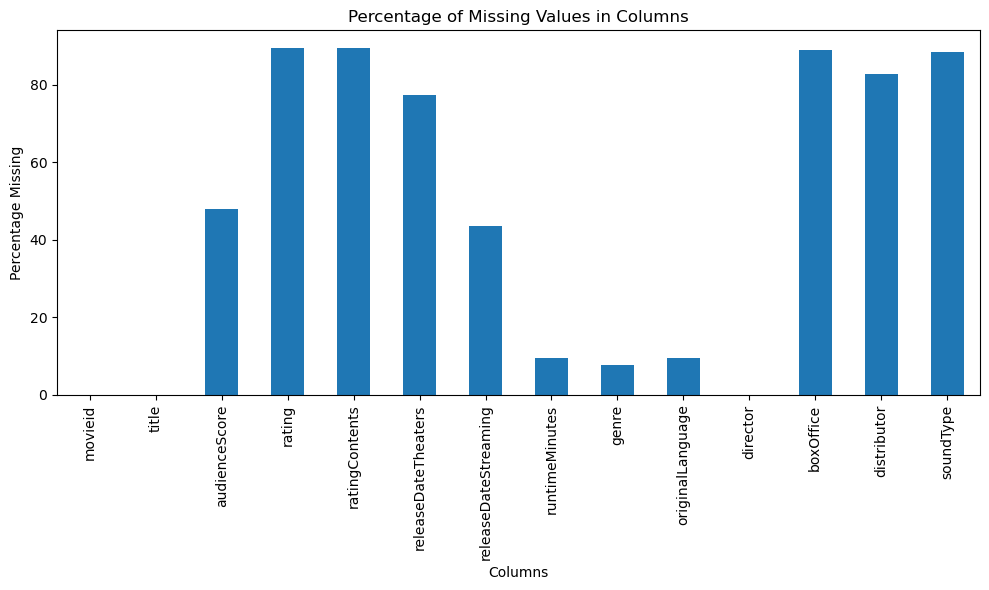

In [22]:
plt.figure(figsize=(10, 6))
missingPercent.plot(kind='bar')
plt.title("Percentage of Missing Values in Columns")
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

* Looking at the above values, we can drop `rating`, `ratingContents`, `releaseDateTheaters` , `boxOffice`, `distributor`, `soundType` because most of the values in these columns are null.

In [23]:
# Dropping columns that are not needed

drop_cols = ['rating', 'ratingContents', 'releaseDateTheaters' , 'boxOffice', 'distributor', 'soundType']

moviesD = moviesD.drop(drop_cols, axis=1)

In [24]:
moviesD.head(2)

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
122446,enthralling_riddle_whisper,Enthralling Riddle Whisper,45.0,2014-01-28,103.0,"Comedy, Drama",English,Billie Aguirre
66214,e.t._dragon_neo_phantom,E.T. Dragon Neo Phantom,53.0,2007-09-25,96.0,"Sci-fi, Action",English,Timothy Baim


* Since `title` and `movieid` are almost same kind of columns, we can remove one of them.

In [25]:
moviesD = moviesD.drop('title', axis = 1)

In [26]:
moviesD.head()

,movieid,audienceScore,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director
122446,enthralling_riddle_whisper,45.0,2014-01-28,103.0,"Comedy, Drama",English,Billie Aguirre
66214,e.t._dragon_neo_phantom,53.0,2007-09-25,96.0,"Sci-fi, Action",English,Timothy Baim
66197,marty_mcfly_gollum_whirlwind_silent,68.0,2016-01-19,121.0,"Adventure, Drama, Mystery & thriller",English,Leroy Fernandes
134379,holly_golightly_travis_bickle_valiant_darth_vader,30.0,1999-12-07,98.0,"Drama, Lgbtq+",English,Lourdes Burgess
27413,the_bride_starlight_illusion_james_bond,79.0,2017-12-12,143.0,"Crime, Drama",English,Donald Sohn


`releaseDateStreaming` is of Date dtype for which imputation won't make any sense and won't contribute much to the sentiment analysis

In [27]:
moviesD = moviesD.drop('releaseDateStreaming', axis = 1)

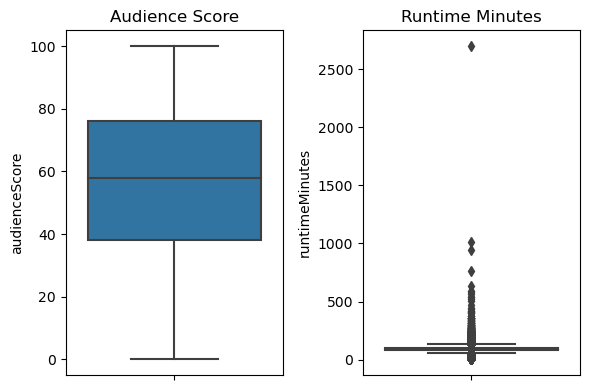

In [28]:
# Checking the distribution of datapoints and checking outliers

fig, axes = plt.subplots(1,2 , figsize=(6, 4))

sns.boxplot(data=moviesD, y='audienceScore',ax=axes[0])
axes[0].set_title('Audience Score')

sns.boxplot(data=moviesD, y='runtimeMinutes',ax=axes[1])
axes[1].set_title('Runtime Minutes')

plt.tight_layout()
plt.show()

* `runTimeMinutes` has so many outliers. We will scale it.

In [29]:
moviesD.columns

Index(['movieid', 'audienceScore', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director'],
      dtype='object')

In [30]:
moviesD.head()

,movieid,audienceScore,runtimeMinutes,genre,originalLanguage,director
122446,enthralling_riddle_whisper,45.0,103.0,"Comedy, Drama",English,Billie Aguirre
66214,e.t._dragon_neo_phantom,53.0,96.0,"Sci-fi, Action",English,Timothy Baim
66197,marty_mcfly_gollum_whirlwind_silent,68.0,121.0,"Adventure, Drama, Mystery & thriller",English,Leroy Fernandes
134379,holly_golightly_travis_bickle_valiant_darth_vader,30.0,98.0,"Drama, Lgbtq+",English,Lourdes Burgess
27413,the_bride_starlight_illusion_james_bond,79.0,143.0,"Crime, Drama",English,Donald Sohn


### Data Imputation :
   * impute the `audienceScore` and `runtimeMinutes` by replacing the null values with 
     the mean values
   * replace the missing values of `genre` and `originalLanguage` with the most 
     frequent values occuring in the respective columns

In [31]:
imputeTransformer = ColumnTransformer([
    ('SI_mean', SimpleImputer(strategy = 'mean'), ['audienceScore','runtimeMinutes']),
    ('SI_mostfreq', SimpleImputer(strategy = 'most_frequent'), ['genre', 'originalLanguage'])
], remainder = 'passthrough', verbose_feature_names_out = False)

transformed_features = imputeTransformer.fit_transform(moviesD)

# Changing our imputed array to dataframe for easier processing

columns = imputeTransformer.get_feature_names_out()
moviesD = pd.DataFrame(transformed_features, columns = columns)

# Sanity check for missing/null values

moviesD.isnull().sum()

audienceScore       0
runtimeMinutes      0
genre               0
originalLanguage    0
movieid             0
director            0
dtype: int64

# <u>**DATA MERGING**</u>

In [32]:
# Merging train dataset and movies dataset

train_merged = pd.merge(trainD, moviesD, on='movieid', how='left')

In [33]:
train_merged.shape

(162758, 10)

In [34]:
train_merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director'],
      dtype='object')

In [35]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
 5   audienceScore       162758 non-null  object
 6   runtimeMinutes      162758 non-null  object
 7   genre               162758 non-null  object
 8   originalLanguage    162758 non-null  object
 9   director            162758 non-null  object
dtypes: bool(1), object(9)
memory usage: 12.6+ MB


In [36]:
train_merged.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,runtimeMinutes,genre,originalLanguage,director
count,162758,162758,162758,156311,162758,162758.0,162758.0,162758,162758,162758
unique,16812,4482,2,155071,2,100.0,206.0,1193,88,8828
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE,86.0,90.0,Drama,English,Billy Diaz
freq,708,962,113189,29,108761,3842.0,4732.0,22088,140732,857


In [37]:
# Null Percentage of the Merged Dataset

(train_merged.isnull().sum()/ len(train_merged)) * 100

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
audienceScore         0.000000
runtimeMinutes        0.000000
genre                 0.000000
originalLanguage      0.000000
director              0.000000
dtype: float64

In [38]:
train_merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director'],
      dtype='object')

In [39]:
train_merged['reviewText'].fillna('',inplace=True)

In [40]:
# Dropping duplicate rows from merged dataset

train_merged = train_merged.drop_duplicates(keep='first')

In [41]:
train_merged['director'].value_counts().head()

Billy Diaz          836
Michelle Numbers    706
Linda Shuffler      638
Sheila Pereira      607
Jill Fraser         603
Name: director, dtype: int64

In [42]:
# Processing on Director Column

sorted_directors = train_merged['director'].value_counts().sort_values(ascending=False)

count = 0
selected_directors = []
topDirectors = []

for dirCount, dirName in zip(sorted_directors, sorted_directors.index):
    count += dirCount
    topDirectors.append(dirName)
    selected_directors.append(dirCount)

    if count > 0.55 * len(moviesD):
        break
        
train_merged['topDirector'] = train_merged['director'].isin(topDirectors).astype(int)

In [43]:
train_merged.head(3)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,runtimeMinutes,genre,originalLanguage,director,topDirector
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.0,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,1
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,47.0,119.0,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,1
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,80.0,130.0,Drama,English,Bobby Oleary,0


* Automated EDA for better analysis

In [44]:
#Pandas Profiling for Automated EDA of the final dataset we will use for further preprocessing

from ydata_profiling import ProfileReport

dataset_profile = ProfileReport(train_merged)
dataset_profile

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# <u>**DATA PREPROCESSING**</u>

#### `genre` Column

* Step-1 Removing Punctuation Marks
* Step-2 Converting to LowerCase
* Step-3 Getting Unique Genres
* Step-4 Encode it with Custom Function

In [45]:
# Remove commas and ampersands from the genre column and replace them with spaces
train_merged['genre'] = train_merged['genre'].str.replace(',', '').str.replace(' & ', '&')

# converting to lowercase
train_merged['genre'] = train_merged['genre'].str.lower()

''' To get unique genre I'll create a new column with name -- `genres` ''' 

# Split the genre column into separate genres
train_merged['genres'] = train_merged['genre'].str.split()

# Explode the DataFrame to create multiple rows for each genre entry
train_merged_exploded = train_merged.explode('genres', ignore_index=True)

# Strip whitespace from the genre entries
train_merged_exploded['genres'] = train_merged_exploded['genres'].str.strip()

# Get the unique genres
unique_genres = train_merged_exploded['genres'].unique()

print('No. of Genres: ', len(unique_genres))
print(unique_genres)

### Encode it with Custom Function

def is_genre(name, glist):
  if name in glist:
    return 1
  else:
    return 0

genre_dict = {
    name : train_merged['genres'].apply(lambda x: is_genre(name,x)) for name in unique_genres
}

genre_df = pd.DataFrame(genre_dict)

No. of Genres:  33
['comedy' 'animation' 'adventure' 'fantasy' 'holiday' 'romance' 'lgbtq+'
 'drama' 'action' 'mystery&thriller' 'sci-fi' 'crime' 'documentary'
 'kids&family' 'music' 'history' 'biography' 'horror' 'war' 'musical'
 'anime' 'western' 'sports' 'short' 'foreign' 'nature' 'sports&fitness'
 'stand-up' 'news' 'health&wellness' 'faith&spirituality' 'gay&lesbian'
 'variety']


In [46]:
''' Merging this dataframe with the feature_data dataframe

    1. drop the genre and genres column
    2. merge genre_df with feature_data '''

# Dropping columns
train_merged.drop(['genre', 'genres'], axis = 1, inplace = True)

# Merging
train_merged = pd.merge(train_merged, genre_df, left_index = True, right_index=True)
print('Shape of Matrix: ',train_merged.shape)

Shape of Matrix:  (161640, 43)


* #### Let us separate the features and our target variable

In [47]:
# making of copy of our merged dataset so as to not lose the original info
mergedTrain = train_merged.copy()

# Changing the datatype of sentiment to int
mergedTrain['sentiment'] = mergedTrain['sentiment'].replace('POSITIVE', 1).replace("NEGATIVE", 0)

* Making a column for weighted genre to deal with it in a better way

In [48]:
corrSentiment = mergedTrain.corr()['sentiment'].drop('sentiment')

# Calculate the weighted sum for each row based on genre values and correlations

def weighted_genre(row):
    genre_values = row.iloc[9:]  # Select genre columns
    weighted_sum = sum([value * corrSentiment[genre] for genre, value in genre_values.items()])
    return weighted_sum

# Apply the weighted_genre function to each row

mergedTrain['genre_W'] = mergedTrain.apply(weighted_genre, axis=1)

/tmp/ipykernel_20/229807985.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrSentiment = mergedTrain.corr()['sentiment'].drop('sentiment')


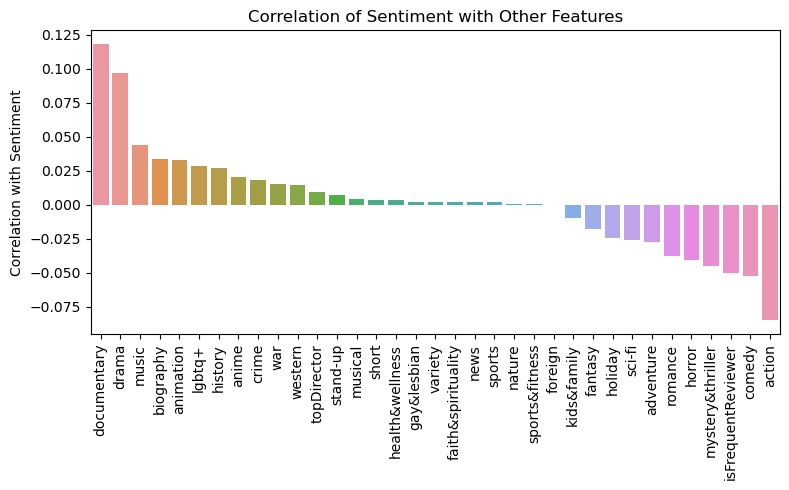

In [49]:
# Create a DataFrame from the correlation coefficients
correlation_df = pd.DataFrame({'Correlation with Sentiment': corrSentiment})
correlation_df = correlation_df.sort_values(by='Correlation with Sentiment', ascending=False)
plt.figure(figsize=(8, 5))

sns.barplot(x = correlation_df.index, y='Correlation with Sentiment', data = correlation_df)
plt.xticks(rotation = 90)

plt.title('Correlation of Sentiment with Other Features')

plt.tight_layout()
plt.show()

In [50]:
mergedTrain['sentiment'].corr(mergedTrain['genre_W'])

0.16622539947146983

In [51]:
train_merged = train_merged.merge(mergedTrain['genre_W'], left_index = True, right_index = True)

In [52]:
train_merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'runtimeMinutes', 'originalLanguage',
       'director', 'topDirector', 'comedy', 'animation', 'adventure',
       'fantasy', 'holiday', 'romance', 'lgbtq+', 'drama', 'action',
       'mystery&thriller', 'sci-fi', 'crime', 'documentary', 'kids&family',
       'music', 'history', 'biography', 'horror', 'war', 'musical', 'anime',
       'western', 'sports', 'short', 'foreign', 'nature', 'sports&fitness',
       'stand-up', 'news', 'health&wellness', 'faith&spirituality',
       'gay&lesbian', 'variety', 'genre_W'],
      dtype='object')

In [53]:
features = train_merged.drop('sentiment', axis = 1)
label = train_merged['sentiment']

print('Shape of Data Matrix:' , features.shape)
print('Shape of Label Vector:' , label.shape)

Shape of Data Matrix: (161640, 43)
Shape of Label Vector: (161640,)


In [54]:
features.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'runtimeMinutes', 'originalLanguage', 'director',
       'topDirector', 'comedy', 'animation', 'adventure', 'fantasy', 'holiday',
       'romance', 'lgbtq+', 'drama', 'action', 'mystery&thriller', 'sci-fi',
       'crime', 'documentary', 'kids&family', 'music', 'history', 'biography',
       'horror', 'war', 'musical', 'anime', 'western', 'sports', 'short',
       'foreign', 'nature', 'sports&fitness', 'stand-up', 'news',
       'health&wellness', 'faith&spirituality', 'gay&lesbian', 'variety',
       'genre_W'],
      dtype='object')

In [55]:
features.drop(['originalLanguage', 'director'], axis = 1, inplace = True)
features.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'runtimeMinutes', 'topDirector', 'comedy', 'animation',
       'adventure', 'fantasy', 'holiday', 'romance', 'lgbtq+', 'drama',
       'action', 'mystery&thriller', 'sci-fi', 'crime', 'documentary',
       'kids&family', 'music', 'history', 'biography', 'horror', 'war',
       'musical', 'anime', 'western', 'sports', 'short', 'foreign', 'nature',
       'sports&fitness', 'stand-up', 'news', 'health&wellness',
       'faith&spirituality', 'gay&lesbian', 'variety', 'genre_W'],
      dtype='object')

In [56]:
features.drop(features.columns[7:-1], axis = 1, inplace = True)

In [57]:
# Converting to int format for transforming purposes

features['isFrequentReviewer'] = features['isFrequentReviewer'].astype(int)

In [58]:
features.isnull().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
audienceScore         0
runtimeMinutes        0
topDirector           0
genre_W               0
dtype: int64

### Train-Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, shuffle = True, stratify = label, random_state = 16)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(129312, 8) (129312,)
(32328, 8) (32328,)


### Feature Scaling and Encoding

* For Categorical columns we will proceed with encoding and we will scale the numerical columns

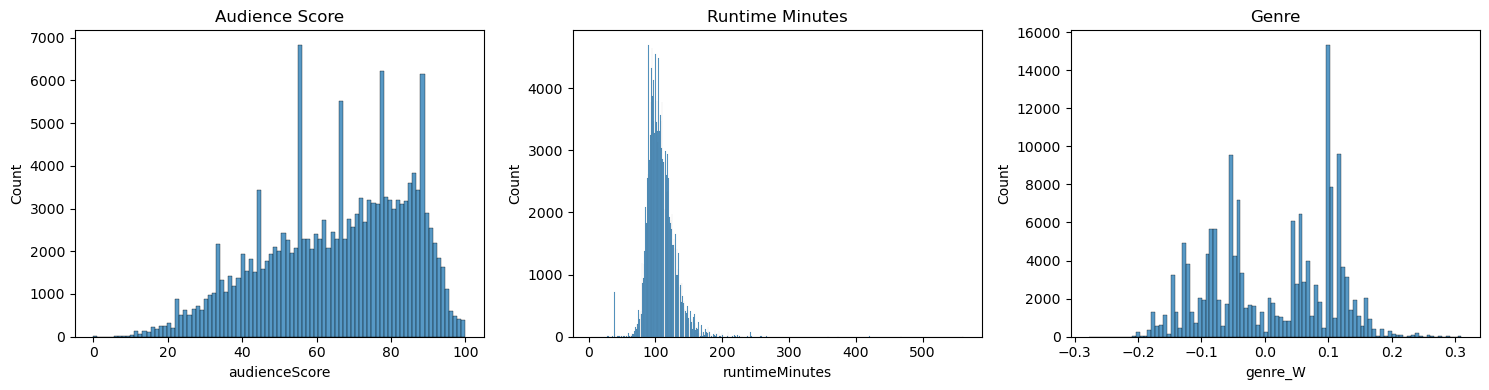

In [60]:
# Plotting Bar Chart to check the distribution of audienceScore so as to choose the best scaling technique

fig, axes = plt.subplots(1,3 , figsize=(15, 4))

sns.histplot(data = features, x='audienceScore',ax=axes[0])
axes[0].set_title('Audience Score')

sns.histplot(data = features, x='runtimeMinutes',ax=axes[1])
axes[1].set_title('Runtime Minutes')

sns.histplot(data = features, x='genre_W',ax=axes[2])
axes[2].set_title('Genre')

plt.tight_layout()
plt.show()

#### <u>**Complete Data**</u>

In [61]:
# Scaling and Encoding

dataTransformer1 = ColumnTransformer([
    ('vect_movie' , TfidfVectorizer() , 'movieid'),
    ('vect_reviewer' , TfidfVectorizer() , 'reviewerName'),
    ('scaling', MinMaxScaler(), ['audienceScore','runtimeMinutes','genre_W']),
    ('vectorize' , TfidfVectorizer(ngram_range = (1,3), min_df = 4 , max_df =0.4) , 'reviewText')
],remainder = 'passthrough')

training_features = dataTransformer1.fit_transform(features)

print(training_features.shape)

(161640, 217918)


#### <u>**Splitted Data**</u>

In [62]:
# Scaling and Encoding

dataTransformer2 = ColumnTransformer([
    ('vect_movie' , TfidfVectorizer() , 'movieid'),
    ('vect_reviewer' , TfidfVectorizer() , 'reviewerName'),
    ('scaling', MinMaxScaler(), ['audienceScore','runtimeMinutes','genre_W']),
    ('vectorize' , TfidfVectorizer(ngram_range = (1,3), min_df = 4 , max_df =0.4) , 'reviewText')
],remainder = 'passthrough')

trans_X = dataTransformer2.fit_transform(X_train)

print(trans_X.shape)

(129312, 180241)


# <u>**TRANSFORMING VALIDATION SET**</u>

In [63]:
# Encoding and Scaling rest of the columns
validation_features = dataTransformer2.transform(X_test)

print('Shape of Validation Features:' , validation_features.shape)

Shape of Validation Features: (32328, 180241)


# <u>**MODEL-1 LOGISTIC REGRESSION**</u>

## Model Training

#### <u>**Complete Data**</u>

In [64]:
logRegModel = LogisticRegression(max_iter = 500, solver = 'saga', C = 10000, tol = 0.02, random_state = 16)
logRegModel.fit(training_features, label)

LogisticRegression(C=10000, max_iter=500, random_state=16, solver='saga',
                   tol=0.02)

* Cross Validation Score

In [65]:
response = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state = 16)

logReg_results = cross_validate(logRegModel, training_features, response, scoring = 'f1_macro', cv = split, n_jobs = -1, return_train_score = True)

pd.DataFrame(logReg_results)

,fit_time,score_time,test_score,train_score
0,4.688783,0.029240,0.812909,0.953768
1,4.310611,0.027591,0.810541,0.949489
2,4.652140,0.031183,0.812543,0.953345
3,4.217325,0.033106,0.811604,0.949770
4,2.605489,0.019449,0.812502,0.953834


#### <u>**Splitted Data**</u>

In [66]:
logRegModel2 = LogisticRegression(max_iter = 500, C = 10000, solver = 'saga', tol = 0.02, random_state = 16)
logRegModel2.fit(trans_X, y_train)

LogisticRegression(C=10000, max_iter=500, random_state=16, solver='saga',
                   tol=0.02)

* Confusion Matrix and Classfication Report

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.71      0.74     10725
    POSITIVE       0.86      0.90      0.88     21603

    accuracy                           0.84     32328
   macro avg       0.82      0.81      0.81     32328
weighted avg       0.84      0.84      0.84     32328



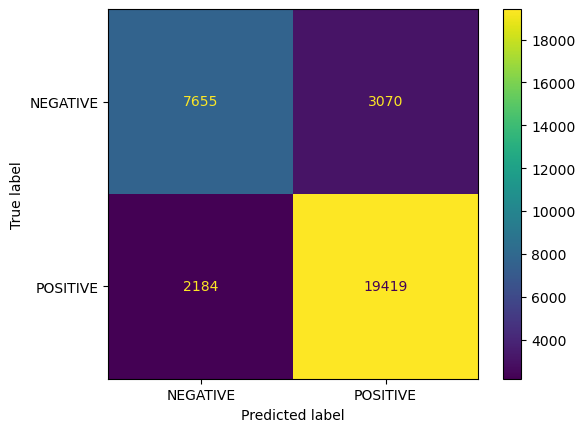

In [67]:
prediction = logRegModel2.predict(validation_features)

print(classification_report(y_test, prediction))

print(ConfusionMatrixDisplay.from_estimator(logRegModel2, validation_features, y_test))
plt.show()

* Precision-Recall Curve

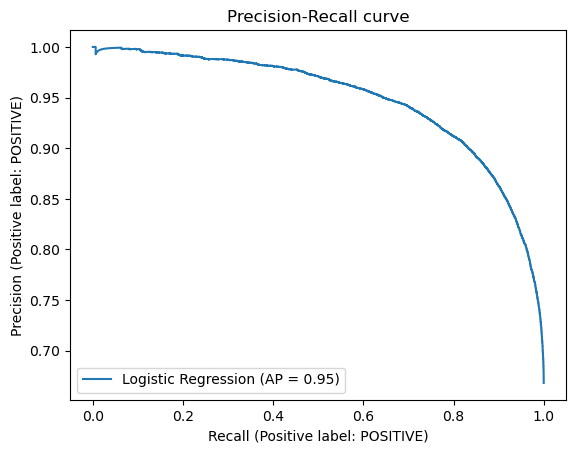

In [68]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(logRegModel2, validation_features, y_test, name="Logistic Regression")
_ = display.ax_.set_title("Precision-Recall curve")

* ### HyperParameter Tuning

In [69]:
encoded_label = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state = 16)

param_grid = [
    {
        'max_iter': [500, 1000],                     #2
        'C': [5000, 10000],                          #2                 
        'solver': ['saga'],                          #1               
        'tol' : [0.02 , 0.01]                        #2
    }  
]

gslogit = GridSearchCV(LogisticRegression(), 
                       param_grid = param_grid, 
                       cv = split, 
                       scoring = 'f1_macro', 
                       verbose = True, 
                       n_jobs= -1, 
                       return_train_score = True)

In [70]:
gslogit.fit(training_features, encoded_label)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=16, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [5000, 10000], 'max_iter': [500, 1000],
                          'solver': ['saga'], 'tol': [0.02, 0.01]}],
             return_train_score=True, scoring='f1_macro', verbose=True)

In [71]:
print(gslogit.best_params_)
print(gslogit.best_score_)

{'C': 10000, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.02}
0.8125746009979873


In [72]:
results = pd.DataFrame(gslogit.cv_results_)
results[results['rank_test_score'] == 1].loc[: , ['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
6,"{'C': 10000, 'max_iter': 1000, 'solver': 'saga...",0.812575,0.951449


# <u>**MODEL-2 NAIVE BAYES CLASSIFIER**</u>

## Model Training

#### <u>**Complete Data**</u>

In [73]:
naiveModel = MultinomialNB(alpha = 0.25, force_alpha = True, fit_prior = True, class_prior = [0.42, 0.58])
naiveModel.fit(training_features, label)

MultinomialNB(alpha=0.25, class_prior=[0.42, 0.58], force_alpha=True)

* Cross Validation Score

In [74]:
response = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=16)

naive_results = cross_validate(naiveModel, training_features, response, scoring = 'f1_macro', cv = split, n_jobs = -1, return_train_score = True)

pd.DataFrame(naive_results)

,fit_time,score_time,test_score,train_score
0,0.233702,0.042632,0.797323,0.896357
1,0.226443,0.040051,0.798598,0.896544
2,0.225447,0.045494,0.798308,0.897022
3,0.228045,0.043584,0.797434,0.896363
4,0.142285,0.026478,0.799700,0.896281


#### <u>**Splitted Data**</u>

In [75]:
naiveModel2 = MultinomialNB(alpha = 0.25, force_alpha = True, fit_prior = True, class_prior = [0.4, 0.6])
naiveModel2.fit(trans_X, y_train)

MultinomialNB(alpha=0.25, class_prior=[0.4, 0.6], force_alpha=True)

* Confusion Matrix and Classification Report

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.73      0.73     10725
    POSITIVE       0.87      0.86      0.86     21603

    accuracy                           0.82     32328
   macro avg       0.80      0.80      0.80     32328
weighted avg       0.82      0.82      0.82     32328



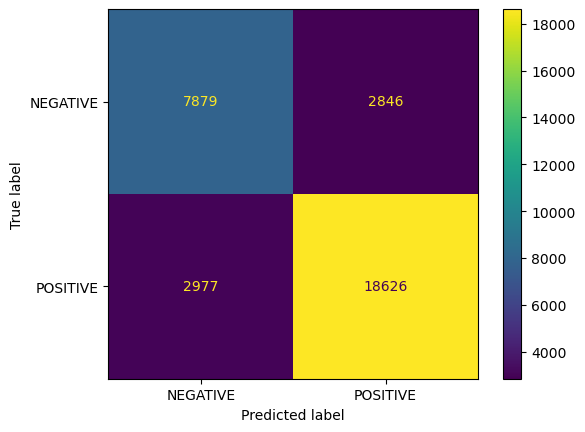

In [76]:
prediction = naiveModel2.predict(validation_features)

print(classification_report(y_test, prediction))

print(ConfusionMatrixDisplay.from_estimator(naiveModel2, validation_features, y_test))
plt.show()

* Precision-Recall Curve

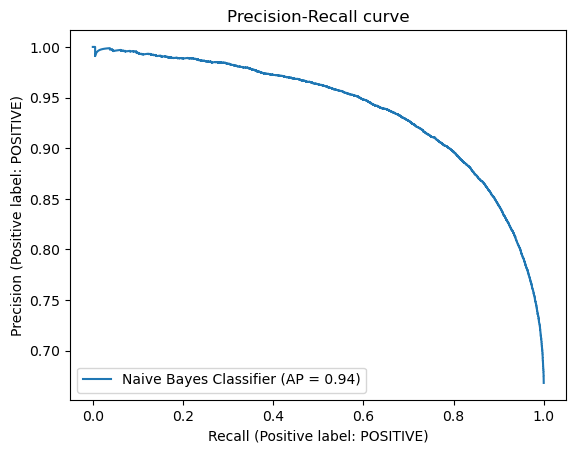

In [77]:
display = PrecisionRecallDisplay.from_estimator(naiveModel2, validation_features, y_test, name="Naive Bayes Classifier")
_ = display.ax_.set_title("Precision-Recall curve")

* ### HyperParameter Tuning

In [78]:
encoded_label = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=16)

param_grid = [
    {
        'alpha' : [0.1, 0.15, 0.2, 0.25],
        'force_alpha' : [True, False],
        'fit_prior' : [True, False],
        'class_prior' : [None, [0.42, 0.58], [0.4, 0.6]]
    }
]

gsNaive = GridSearchCV(MultinomialNB(),
                       param_grid = param_grid,
                       cv = split,
                       scoring = 'f1_macro',
                       verbose = True,
                       n_jobs= -1,
                       return_train_score = True)

gsNaive.fit(training_features, encoded_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=16, test_size=0.2,
            train_size=None),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid=[{'alpha': [0.1, 0.15, 0.2, 0.25],
                          'class_prior': [None, [0.42, 0.58], [0.4, 0.6]],
                          'fit_prior': [True, False],
                          'force_alpha': [True, False]}],
             return_train_score=True, scoring='f1_macro', verbose=True)

In [79]:
print(gsNaive.best_params_)
print(gsNaive.best_score_)

{'alpha': 0.25, 'class_prior': [0.4, 0.6], 'fit_prior': True, 'force_alpha': True}
0.7987274426828284


In [80]:
naive_results = pd.DataFrame(gsNaive.cv_results_)
naive_results[naive_results['rank_test_score'] == 1].loc[: , ['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
44,"{'alpha': 0.25, 'class_prior': [0.4, 0.6], 'fi...",0.798727,0.897488
45,"{'alpha': 0.25, 'class_prior': [0.4, 0.6], 'fi...",0.798727,0.897488
46,"{'alpha': 0.25, 'class_prior': [0.4, 0.6], 'fi...",0.798727,0.897488
47,"{'alpha': 0.25, 'class_prior': [0.4, 0.6], 'fi...",0.798727,0.897488


# <u>**MODEL-3 LINEAR SVC**</u>

## Model Training

#### <u>**Complete Data**</u>

In [81]:
lsvcModel = LinearSVC(max_iter = 500, tol = 0.005, C = 0.2, random_state = 16)

lsvcModel.fit(training_features, label)

LinearSVC(C=0.2, max_iter=500, random_state=16, tol=0.005)

* Cross Validation Score

In [82]:
response = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=16)

lsvc_results = cross_validate(lsvcModel, training_features, response, scoring = 'f1_macro', cv = split, n_jobs = -1, return_train_score = True)

pd.DataFrame(lsvc_results)

,fit_time,score_time,test_score,train_score
0,2.468964,0.027792,0.812344,0.931015
1,2.539099,0.029749,0.811384,0.930813
2,2.558525,0.032768,0.812311,0.931118
3,2.494303,0.029023,0.810242,0.930270
4,1.673113,0.020121,0.811359,0.931219


#### <u>**Splitted Data**</u>

In [83]:
lsvcModel2 = LinearSVC(max_iter = 500, tol = 0.005, C = 0.2, random_state = 16)

lsvcModel2.fit(trans_X, y_train)

LinearSVC(C=0.2, max_iter=500, random_state=16, tol=0.005)

* Confusion Matrix and Classification Report

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.70      0.74     10725
    POSITIVE       0.86      0.91      0.88     21603

    accuracy                           0.84     32328
   macro avg       0.83      0.80      0.81     32328
weighted avg       0.84      0.84      0.84     32328



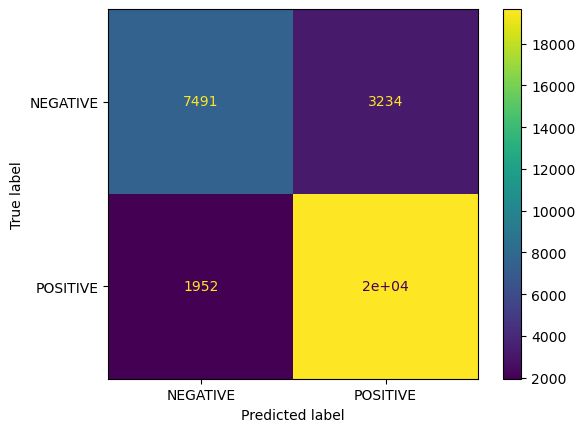

In [84]:
prediction = lsvcModel2.predict(validation_features)

print(classification_report(y_test, prediction))

print(ConfusionMatrixDisplay.from_estimator(lsvcModel2, validation_features, y_test))
plt.show()

* Precision-Recall Curve

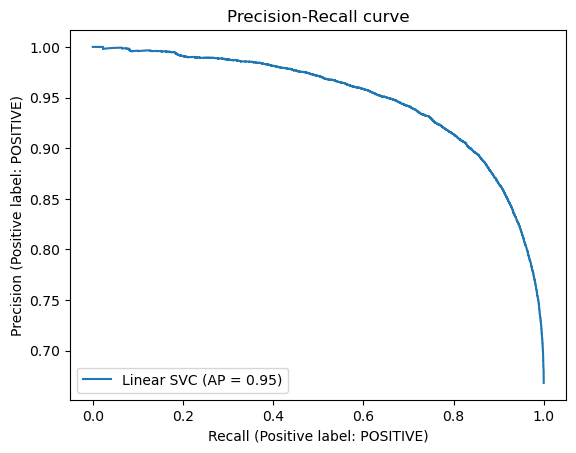

In [85]:
display = PrecisionRecallDisplay.from_estimator(lsvcModel2, validation_features, y_test, name="Linear SVC")
_ = display.ax_.set_title("Precision-Recall curve")

* ### HyperParameter Tuning

In [86]:
response = LabelEncoder().fit_transform(label)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

param_grid = [
    {
        'max_iter': [500, 1000],                                                 
        'C': [0.1, 0.15, 0.2],                      
        'tol' : [0.0005, 0.001, 0.003, 0.005]                            
    }  
]

gsLSVC = GridSearchCV(LinearSVC(), 
                      param_grid = param_grid, 
                      cv = split, 
                      scoring = 'f1_macro', 
                      verbose = True, 
                      n_jobs= -1, 
                      return_train_score = True)

In [87]:
gsLSVC.fit(training_features, response)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.15, 0.2], 'max_iter': [500, 1000],
                          'tol': [0.0005, 0.001, 0.003, 0.005]}],
             return_train_score=True, scoring='f1_macro', verbose=True)

In [88]:
print(gsLSVC.best_params_)
print(gsLSVC.best_score_)

{'C': 0.2, 'max_iter': 500, 'tol': 0.0005}
0.8108316929070323


In [89]:
results = pd.DataFrame(gsLSVC.cv_results_)
results[results['rank_test_score'] == 1].loc[: , ['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
16,"{'C': 0.2, 'max_iter': 500, 'tol': 0.0005}",0.810832,0.931010
17,"{'C': 0.2, 'max_iter': 500, 'tol': 0.001}",0.810832,0.931008
20,"{'C': 0.2, 'max_iter': 1000, 'tol': 0.0005}",0.810832,0.931010
21,"{'C': 0.2, 'max_iter': 1000, 'tol': 0.001}",0.810832,0.931012


# <u>**TEST DATA SET**</u>

In [90]:
print(testDataset.columns)
print(moviesD.columns)

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText'], dtype='object')
Index(['audienceScore', 'runtimeMinutes', 'genre', 'originalLanguage',
       'movieid', 'director'],
      dtype='object')


In [91]:
# CHECKING ACCURACY ON TEST DATA

# first we will merge movies and test dataset

test_merged = pd.merge(testDataset, moviesD, on='movieid', how='left')

print(test_merged.columns)

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText', 'audienceScore',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director'],
      dtype='object')


In [92]:
test_merged.rename(columns = {'isTopCritic' : 'isFrequentReviewer'}, inplace = True)

In [93]:
test_merged['isFrequentReviewer'] = test_merged['isFrequentReviewer'].astype(int)

In [94]:
print(test_merged.isnull().sum())

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            2510
audienceScore            0
runtimeMinutes           0
genre                    0
originalLanguage         0
director                 0
dtype: int64


* ### Transforming the Test DataSet

In [95]:
# removing null values

test_merged['reviewText'] = test_merged['reviewText'].fillna('')

In [96]:
test_merged['topDirector'] = test_merged['director'].isin(topDirectors).astype(int)

In [97]:
test_merged.drop([ 'originalLanguage', 'director'], axis = 1, inplace = True)

In [98]:
test_merged.isnull().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
audienceScore         0
runtimeMinutes        0
genre                 0
topDirector           0
dtype: int64

* Encoding genre

In [99]:
# transform genre column

# Remove commas and ampersands from the genre column and replace them with spaces
test_merged['genre'] = test_merged['genre'].str.replace(',', '').str.replace(' & ', '&')

# converting to lowercase
test_merged['genre'] = test_merged['genre'].str.lower()

''' To get unique genre I'll create a new column with name -- `genres` ''' 

# dealing with null values
#train_merged['genre'] = train_merged['genre'].fillna('')

# Split the genre column into separate genres
test_merged['genres'] = test_merged['genre'].str.split()

# Explode the DataFrame to create multiple rows for each genre entry
test_merged_exploded = test_merged.explode('genres', ignore_index=True)

# Strip whitespace from the genre entries
test_merged_exploded['genres'] = test_merged_exploded['genres'].str.strip()

# Get the unique genres
unique_genres_test = test_merged_exploded['genres'].unique()

print('No. of Genres: ', len(unique_genres_test))

### Encode it with Custom Function

def is_genre(name, glist):
  if name in glist:
    return 1
  else:
    return 0

genre_dict_test = {
    name : test_merged['genres'].apply(lambda x: is_genre(name,x)) for name in unique_genres_test
}

genre_test = pd.DataFrame(genre_dict_test)


# dropping genre and genres columns
test_merged.drop(['genre', 'genres'], axis = 1, inplace = True)

# merging
test_merged = pd.merge(test_merged, genre_test, left_index = True, right_index=True)
print('Shape of Test matrix :' , test_merged.shape)

No. of Genres:  33
Shape of Test matrix : (55315, 40)


In [100]:
corrSentiment = mergedTrain.corr()['sentiment']

# Extract the correlations as weights for columns from the 3rd to second last column
colWeights = corrSentiment.iloc[3:-1]

# Calculate the weighted genre column in test_merged using the column weights
test_merged['genre_W'] = (test_merged[colWeights.index] * colWeights).sum(axis=1)

/tmp/ipykernel_20/3587373689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrSentiment = mergedTrain.corr()['sentiment']


In [101]:
test_merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'runtimeMinutes', 'topDirector', 'holiday', 'horror',
       'mystery&thriller', 'drama', 'adventure', 'musical', 'comedy', 'lgbtq+',
       'crime', 'sci-fi', 'action', 'fantasy', 'documentary', 'war', 'romance',
       'history', 'western', 'kids&family', 'animation', 'stand-up',
       'biography', 'music', 'anime', 'foreign', 'short', 'sports', 'news',
       'health&wellness', 'nature', 'sports&fitness', 'variety', 'gay&lesbian',
       'faith&spirituality', 'genre_W'],
      dtype='object')

In [102]:
test_merged = test_merged.drop(test_merged.columns[7:-1], axis=1)

In [103]:
test_merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'runtimeMinutes', 'topDirector', 'genre_W'],
      dtype='object')

In [104]:
test_merged.head(2)

,movieid,reviewerName,isFrequentReviewer,reviewText,audienceScore,runtimeMinutes,topDirector,genre_W
0,legend_marty_mcfly_oracle,John Kim,0,Green slowly cranks up the dread with style an...,57.0,111.0,1,-0.110625
1,terminator_katniss_everdeen_glimmer,Brian Chaney,0,Philip Noyce's direction is elegant and unforc...,86.0,94.0,1,0.069365


* Encoding and Scaling features

In [105]:
test_features = dataTransformer1.transform(test_merged)

In [106]:
# checking number of features in training data and test data are same or not

test_features.shape[1] == training_features.shape[1]

True

# <u>**SUBMISSION FILE**</u>

In [107]:
# MODEL-1
# Logistic Regression Model
# test_predictions = logRegModel.predict(test_features) # score = 0.84474

# MODEL-2
# Naive Bayes Classifier
# test_predictions = naiveModel.predict(test_features) # score = 0.82351

# MODEL-3
# Linear SVC
test_predictions = lsvcModel.predict(test_features)

In [108]:
# SUBMISSIONS

submission_file = pd.DataFrame({'sentiment': test_predictions})
submission_file.index.names = ['id']
submission_file.to_csv('submission.csv')

In [109]:
submission_file.shape

(55315, 1)

In [110]:
submission_file.value_counts()

sentiment
POSITIVE     38978
NEGATIVE     16337
dtype: int64